In [1]:
'''
@Params: directory of json files and directory of corresponding frames. Make sure that json files has name like <number>.json
        for example: 897.json and the corresponding image file has name frame_897.jpg

TO RUN
command: python classify_data_by_angle.py -j <json_files_directory> -f <frames_directory>

OUTPUT: two directory: one for up images and the other is for down images
'''

import json
import sys
import cv2
import numpy as np
import math
import os, sys, shutil
import argparse
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os, sys, shutil

In [2]:
class Point(object):
    def __init__(self, x, y, c):
        self.x=x     # x_coordinate of the point
        self.y=y     # y_coordinate of the point
        self.c=c     # confidence of the point

    def __repr__(self):
        return 'x: '+str(self.x)+", y: "+str(self.y)+", c: "+str(self.c)

In [3]:
jsons_dir = './json/'

In [4]:
result_arr = []
label_arr = []

In [5]:
for json_file in os.listdir(jsons_dir):

    json_no = str((json_file.split('.')[0]))
    with open(jsons_dir+json_file) as f:
        data = json.loads(f.read())

    person = data['people'][0]
    pose= person['pose_keypoints_2d']
    face = person['face_keypoints_2d']
    left_hand = person['hand_left_keypoints_2d']
    right_hand = person['hand_right_keypoints_2d']

    ########## EXTRACT POSE POINTS  ##########
    i = 0
    pose_points = []
    for i in range(0, len(pose), 3):
        temp = Point(pose[i],pose[i+1],pose[i+2])
        pose_points.append(temp)    # add this point to pose point array

    ########## EXTRACT FACE POINTS  ##########
    i = 0
    face_points = []
    for i in range(0, len(face), 3):
        temp = Point(face[i],face[i+1],face[i+2])
        face_points.append(temp)    # add this point to pose point array
        i+=3


    ########## EXTRACT LEFT HAND POINTS  ##########
    i = 0
    lhand_points = []
    for i in range(0, len(left_hand), 3):
        temp = Point(left_hand[i],left_hand[i+1],left_hand[i+2])
        lhand_points.append(temp)    # add this point to pose point array
        i+=3


    ########## EXTRACT RIGHT HAND POINTS  ##########
    i = 0
    rhand_points = []
    for i in range(0, len(right_hand), 3):
        temp = Point(right_hand[i],right_hand[i+1],right_hand[i+2])
        rhand_points.append(temp)    # add this point to pose point array
        i+=3
    
    # neck:1, nose: 0,
    #left: 4, right: 7
    
    # CALCULATE LEFT DISTANCE
    left_to_neck = math.sqrt((math.pow(pose_points[4].x-pose_points[1].x,2)+math.pow(pose_points[4].y-pose_points[1].y,2)))
    left_to_nose = math.sqrt((math.pow(pose_points[4].x-pose_points[0].x,2)+math.pow(pose_points[4].y-pose_points[0].y,2)))
    
    threshold = 0.1
    if pose_points[4].c < threshold:
        left_to_neck = None
        left_to_nose = None
        continue
    
    # CALCULATE RIGHT DISTANCE
    right_to_neck = math.sqrt((math.pow(pose_points[7].x-pose_points[1].x,2)+math.pow(pose_points[7].y-pose_points[1].y,2)))
    right_to_nose = math.sqrt((math.pow(pose_points[7].x-pose_points[0].x,2)+math.pow(pose_points[7].y-pose_points[0].y,2)))
    if pose_points[4].c < threshold:
        right_to_neck = None
        right_to_nose = None
        continue
    
    # CALCULATE LEFT FINGERS
    l_thumb = math.sqrt((math.pow(lhand_points[4].x-rhand_points[0].x,2)+math.pow(lhand_points[4].y-rhand_points[0].y,2)))
    l_index = math.sqrt((math.pow(lhand_points[8].x-rhand_points[0].x,2)+math.pow(lhand_points[8].y-rhand_points[0].y,2)))
    l_middle = math.sqrt((math.pow(lhand_points[12].x-rhand_points[0].x,2)+math.pow(lhand_points[12].y-rhand_points[0].y,2)))
    l_ring = math.sqrt((math.pow(lhand_points[16].x-rhand_points[0].x,2)+math.pow(lhand_points[16].y-rhand_points[0].y,2)))
    l_pinky = math.sqrt((math.pow(lhand_points[20].x-rhand_points[0].x,2)+math.pow(lhand_points[20].y-rhand_points[0].y,2)))
    
    if lhand_points[4].c < threshold:
        l_thumb = None
        continue
    if lhand_points[8].c < threshold:
        l_index = None
        continue
    if lhand_points[12].c < threshold:
        l_middle = None
        continue
    if lhand_points[16].c < threshold:
        l_ring = None
        continue
    if lhand_points[20].c < threshold:
        l_pinky = None
        continue
    
    # CALCULATE RIGHT FINGERS
    r_thumb = math.sqrt((math.pow(rhand_points[4].x-rhand_points[0].x,2)+math.pow(rhand_points[4].y-rhand_points[0].y,2)))
    r_index = math.sqrt((math.pow(rhand_points[8].x-rhand_points[0].x,2)+math.pow(rhand_points[8].y-rhand_points[0].y,2)))
    r_middle = math.sqrt((math.pow(rhand_points[12].x-rhand_points[0].x,2)+math.pow(rhand_points[12].y-rhand_points[0].y,2)))
    r_ring = math.sqrt((math.pow(rhand_points[16].x-rhand_points[0].x,2)+math.pow(rhand_points[16].y-rhand_points[0].y,2)))
    r_pinky = math.sqrt((math.pow(rhand_points[20].x-rhand_points[0].x,2)+math.pow(rhand_points[20].y-rhand_points[0].y,2)))
    
            
    if rhand_points[4].c < threshold:
        r_thumb = None
        continue
    if rhand_points[8].c < threshold:
        r_index = None
        continue
    if rhand_points[12].c < threshold:
        r_middle = None
        continue
    if rhand_points[16].c < threshold:
        r_ring = None
        continue
    if rhand_points[20].c < threshold:
        r_pinky = None
        continue
            
    
    temp_arr = [left_to_neck, left_to_nose, right_to_neck, right_to_nose, l_thumb, l_index, l_middle, l_ring, l_pinky,
               r_thumb, r_index, r_middle, r_ring, r_pinky]
    
    result_arr.append(temp_arr)
    label_arr.append(json_no)
    #print(str(len(result_arr))+", "+str(len(label_arr))+", "+str(json_no))

In [6]:
res = np.asarray(result_arr)
label = np.asarray(label_arr)
x = np.zeros(431)

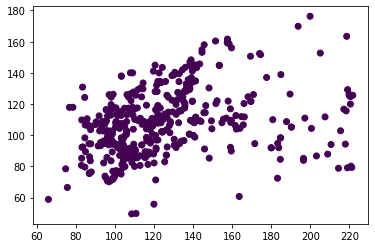

In [7]:
x_axis = res[:,0]  # left distance
y_axis = res[:,2]  # right distance

# Plotting
plt.scatter(x_axis, y_axis, c=x)
plt.show()

In [8]:
model = KMeans(n_clusters=10)
model.fit(res)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [9]:
res[:3]

array([[187.88227741, 296.91614376, 108.72914201, 153.31818486,
        260.30842932, 280.54584287, 261.81443585, 242.83123676,
        219.74012861,  84.62736016, 103.66740056, 105.15763493,
        102.40019664, 101.92989253],
       [146.56330487, 259.17399375, 119.02041321, 159.34300479,
        258.65608345, 266.53238065, 248.02808392, 225.00228231,
        193.95038285,  88.9288691 , 100.73782172, 101.54732141,
         97.42116411,  98.60407104],
       [126.66164736, 237.45092351, 125.62630248, 163.90672751,
        248.4295425 , 247.21059706, 227.03709962, 200.03551429,
        172.29023324,  85.31783885, 100.4742254 , 100.32583143,
        105.45507692, 100.23090439]])

In [10]:
predicted_label = model.predict([[187.88227741, 296.91614376, 108.72914201, 153.31818486,
        260.30842932, 280.54584287, 261.81443585, 242.83123676,
        219.74012861,  84.62736016, 103.66740056, 105.15763493,
        102.40019664, 101.92989253]])

all_predictions = model.predict(res)

# Printing Predictions
print(predicted_label)
print(all_predictions)

[4]
[4 2 2 2 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 0 2 1 1 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 9 2 4 4 4 4 8 8 0 0 0 0
 0 5 5 5 5 5 5 5 5 5 5 9 9 5 1 1 1 9 9 1 1 1 1 1 1 5 5 5 5 7 6 6 6 6 6 6 7
 5 7 7 0 0 0 4 3 3 3 3 2 1 5 1 3 3 2 2 9 9 2 2 2 2 9 9 1 1 1 5 3 3 3 2 2 2
 7 7 0 0 0 0 0 8 8 8 8 8 8 8 6 6 6 6 7 7 5 5 5 5 5 5 5 5 5 5 9 2 2 9 9 9 5
 5 6 6 6 6 6 6 6 5 5 5 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 8 8 8 0 0 0 0 7
 5 3 3 3 5 1 1 1 1 1 1 1 9 2 1 1 5 5 5 3 3 0 0 0 3 0 0 5 5 3 3 3 9 9 9 1 3
 3 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 5 5 5 5 6 8 7 6 5 5 5 8 5 3 3 3 3 5 5 5 6
 1 1 1 5 1 1 1 5 5 3 5 5 5 1 5 5 5 5 5 5 1 1 5 1 2 4 4 9 9 6 6 6 6 6 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 2 2 2 2 8 2 2 2 2 2 2 9 1 5 5 3 3 9 9 9 9 9 9 3
 3 3 3 3 3 3 1 1 5 5 1 1 1 1 5 5 5 5 1 9 9 6 6 6 7 7 7 6 6 2 2 6 6 6 6 6 2
 6 6 6 6 6 6 6 6 6 6 7 7 8 8 8 8 8 8 8 8 8 8 8 0]


In [14]:
for i in range(0,9):
    os.mkdir("./"+str(i))

In [15]:
for i in range(len(all_predictions)):
    shutil.copy("./frames/frame"+str(label[i])+".jpg", "./"+str(all_predictions[i]), follow_symlinks=True)

In [6]:
'''
sc = StandardScaler()  # Load the standard scaler
sc.fit(result_arr)  # Compute the mean and standard deviation of the feature data
X_scaled = sc.transform(result_arr)  # Scale the feature data to be of mean 0 and variance 1

y = label_arr

print(len(X_scaled))
len(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=1)  


# Split the dataset into 30% testing, and 70% training 

error = []
for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(X_train)
    error.append(kmeans.inertia_)
    
plt.plot(range(1, 10), error)
plt.scatter(3, error[2], c='r', marker='x', label='Elbow')
plt.legend()
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion') # Within cluster sum of squares
plt.show()




# Applying k-Means to the dataset with k=3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
y_kmeans = kmeans.fit_predict(X_train)


#plt.scatter(X_train)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s=100, c='red', label='Centroids')
plt.legend()


#Visualising the clusters
plt.scatter(X_train[y_kmeans == 0, 0], X_train[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Iris-setosa')
plt.scatter(X_train[y_kmeans == 1, 0], X_train[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Iris-versicolour')
plt.scatter(X_train[y_kmeans == 2, 0], X_train[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')

plt.legend()
'''

"\nsc = StandardScaler()  # Load the standard scaler\nsc.fit(result_arr)  # Compute the mean and standard deviation of the feature data\nX_scaled = sc.transform(result_arr)  # Scale the feature data to be of mean 0 and variance 1\n\ny = label_arr\n\nprint(len(X_scaled))\nlen(y)\n\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=1)  \n\n\n# Split the dataset into 30% testing, and 70% training \n\nerror = []\nfor n in range(1, 10):\n    kmeans = KMeans(n_clusters=n, random_state=0)\n    kmeans.fit(X_train)\n    error.append(kmeans.inertia_)\n    \nplt.plot(range(1, 10), error)\nplt.scatter(3, error[2], c='r', marker='x', label='Elbow')\nplt.legend()\nplt.title('The Elbow Method')\nplt.xlabel('Number of clusters')\nplt.ylabel('Distortion') # Within cluster sum of squares\nplt.show()\n\n\n\n\n# Applying k-Means to the dataset with k=3 clusters\nkmeans = KMeans(n_clusters=3, random_state=0)\ny_kmeans = kmeans.fit_predict(X_train)\n\n\n#plt.scatter